In [1]:
!pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 KB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━

In [2]:
import os
import ee
import geemap
import ipywidgets as widgets
import pandas as pd
import numpy as np

In [3]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=SC3BZBx02dmy-KjLYWKs3486U0opIwGb5Z-yHz6medQ&tc=kKRO9wXCgVsNBrS68EaKw8GMkGgj0GY7fIXlMGn7Gfk&cc=iT9w8nx9jYf2WPqedw2ROdfedFuhXd54cxXFhSzW5lA

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh7_9LdWWDmg2W2YUEOLMqaIgUxqj9jv52hlP9qbozYB1ioHdZtzOIg

Successfully saved authorization token.


In [4]:
start_date = '2001-01-01'
end_date = '2005-06-30'

In [5]:
Map = geemap.Map()

geometry = ee.Geometry.Point([77.31037420669234,23.247450711520663])
image = ee.ImageCollection("COPERNICUS/S2_SR") \
            .filterBounds(geometry) \
            .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',20)) \
            .first()
# Create an NDWI image, define visualization parameters and display.
ndwi = image.normalizedDifference(['B3', 'B8'])
# Mask the non-watery parts of the image, where NDWI < 0.4.
ndwiMasked = ndwi.updateMask(ndwi.gte(0.4))
ndwiMasked1= ndwiMasked.toInt()
vectors = ndwiMasked1.reduceToVectors(scale = 30.0, geometryType = 'polygon', eightConnected = False, maxPixels = 10000000, bestEffort=True)


In [6]:
geometry = ee.Geometry.Point([77.31037420669234,23.247450711520663])

Map.addLayer(geometry)
sentinel = ee.ImageCollection("COPERNICUS/S2_SR").filterBounds(vectors) \
               .filterDate(start_date,end_date) \
               .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
               .median()


mndwi = sentinel.normalizedDifference(['B3','B11']).rename('mndwi')
mndwitr = mndwi.gt(0)
ndsi = sentinel.normalizedDifference(['B11','B12']).rename('ndsi')
ndti = sentinel.normalizedDifference(['B4','B3']).rename('ndti')

ndci = sentinel.normalizedDifference(['B5','B4']).rename('ndci')


ph  = ee.Image(8.339).subtract(ee.Image(0.827).multiply(sentinel.select('B1').divide(sentinel.select('B8')))).rename('ph')

dissolvedoxygen  = ee.Image(-0.0167).multiply(sentinel.select('B8')).add(ee.Image(0.0067).multiply(sentinel.select('B9'))).add(ee.Image(0.0083).multiply(sentinel.select('B11'))).add(ee.Image(9.577)).rename('dissolvedoxygen')


In [7]:
col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
.filterDate(start_date,end_date) \
.filterBounds(vectors).median()

temp  = col.select('ST_B.*').multiply(0.00341802).add(149.0).subtract(273.15).rename('temp')



In [10]:
starting = '2001-01-01'
ending = '2005-08-31'

data = ee.ImageCollection('COPERNICUS/S3/OLCI').filterDate(starting, ending).filterBounds(vectors)

rgb = data.select(['Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance'])\
              .median().multiply(ee.Image([0.00876539, 0.0123538, 0.0115198])).clip(vectors)
dm_2021_Jan_August_test = rgb.select('Oa08_radiance').divide(rgb.select('Oa04_radiance')).rename('dom')
suspended_matter_2021_Jan_August_test= rgb.select('Oa08_radiance').divide(rgb.select('Oa06_radiance')).rename('suspended_matter')


latlon = ee.Image.pixelLonLat().addBands(dm_2021_Jan_August_test)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100,
  tileScale = 16);
# get data into three different arrays
data_dom_2021_Jan_August_test = np.array((ee.Array(latlon.get("dom")).getInfo()))

latlon = ee.Image.pixelLonLat().addBands(suspended_matter_2021_Jan_August_test)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100,
  tileScale = 16);
# get data into three different arrays
data_sm_2021_Jan_August_test= np.array((ee.Array(latlon.get("suspended_matter")).getInfo()))

EEException: ignored

In [ ]:
start1 = '2021-01-01'
end1 = '2021-06-30'

In [ ]:
data = ee.ImageCollection('COPERNICUS/S3/OLCI').filterDate(start1, end1).filterBounds(vectors)

rgb = data.select(['Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance'])\
              .median().multiply(ee.Image([0.00876539, 0.0123538, 0.0115198])).clip(vectors)
dm_2021_Jan_June = rgb.select('Oa08_radiance').divide(rgb.select('Oa04_radiance')).rename('dom')
suspended_matter__2021_Jan_June = rgb.select('Oa08_radiance').divide(rgb.select('Oa06_radiance')).rename('suspended_matter')


In [ ]:
latlon = ee.Image.pixelLonLat().addBands(dm_2021_Jan_June)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100,
  tileScale = 16);
# get data into three different arrays
data_dom_2021_Jan_June = np.array((ee.Array(latlon.get("dom")).getInfo()))

In [ ]:
latlon = ee.Image.pixelLonLat().addBands(suspended_matter__2021_Jan_June)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100,
  tileScale = 16);
# get data into three different arrays
data_sm_2021_Jan_June= np.array((ee.Array(latlon.get("suspended_matter")).getInfo()))

In [ ]:
start2 = '2021-07-31'
end2 = '2021-10-31'

data = ee.ImageCollection('COPERNICUS/S3/OLCI').filterDate(start2, end2).filterBounds(vectors)

rgb = data.select(['Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance'])\
              .median().multiply(ee.Image([0.00876539, 0.0123538, 0.0115198])).clip(vectors)
dm_2021_July_Oct = rgb.select('Oa08_radiance').divide(rgb.select('Oa04_radiance')).rename('dom')
suspended_matter__2021_July_Oct = rgb.select('Oa08_radiance').divide(rgb.select('Oa06_radiance')).rename('suspended_matter')

latlon = ee.Image.pixelLonLat().addBands(dm_2021_July_Oct)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100,
  tileScale = 16);
# get data into three different arrays
data_dom_2021_July_Oct = np.array((ee.Array(latlon.get("dom")).getInfo()))

latlon = ee.Image.pixelLonLat().addBands(suspended_matter__2021_July_Oct)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100,
  tileScale = 16);
# get data into three different arrays
data_sm_2021_July_Oct= np.array((ee.Array(latlon.get("suspended_matter")).getInfo()))



start3 = '2021-11-30'
end3 = '2021-12-31'

data = ee.ImageCollection('COPERNICUS/S3/OLCI').filterDate(start3, end3).filterBounds(vectors)

rgb = data.select(['Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance'])\
              .median().multiply(ee.Image([0.00876539, 0.0123538, 0.0115198])).clip(vectors)
dm_2021_Nov_Dec = rgb.select('Oa08_radiance').divide(rgb.select('Oa04_radiance')).rename('dom')
suspended_matter__2021_Nov_Dec = rgb.select('Oa08_radiance').divide(rgb.select('Oa06_radiance')).rename('suspended_matter')

latlon = ee.Image.pixelLonLat().addBands(dm_2021_Nov_Dec)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100,
  tileScale = 16);
# get data into three different arrays
data_dom_2021_Nov_Dec = np.array((ee.Array(latlon.get("dom")).getInfo()))

latlon = ee.Image.pixelLonLat().addBands(suspended_matter__2021_Nov_Dec)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100,
  tileScale = 16);
# get data into three different arrays
data_sm_2021_Nov_Dec = np.array((ee.Array(latlon.get("suspended_matter")).getInfo()))

In [ ]:
latlon = ee.Image.pixelLonLat().addBands(temp)


latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100);

data_lst = np.array((ee.Array(latlon.get("temp")).getInfo()))
# geemap.ee_to_numpy(dataset, region=geometry)

In [ ]:
latlon = ee.Image.pixelLonLat().addBands(ndti)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100);
# get data into three different arrays
data_ndti = np.array((ee.Array(latlon.get("ndti")).getInfo()))

In [ ]:
latlon = ee.Image.pixelLonLat().addBands(ndsi)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100);
# get data into three different arrays
data_ndsi = np.array((ee.Array(latlon.get("ndsi")).getInfo()))

In [ ]:
latlon = ee.Image.pixelLonLat().addBands(ndci)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100);
# get data into three different arrays
data_ndci = np.array((ee.Array(latlon.get("ndci")).getInfo()))

In [ ]:
latlon = ee.Image.pixelLonLat().addBands(dissolvedoxygen)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100,
  tileScale = 16);
# get data into three different arrays
data_do = np.array((ee.Array(latlon.get("dissolvedoxygen")).getInfo()))

In [ ]:
latlon = ee.Image.pixelLonLat().addBands(ph)
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=vectors,
  scale=100);
# get data into three different arrays
data_ph = np.array((ee.Array(latlon.get("ph")).getInfo()))

In [ ]:
dm = [pd.DataFrame(data_dom_2021_Jan_June, columns = ['Dissolved Organic Matter']),\
      pd.DataFrame(data_dom_2021_July_Oct, columns = ['Dissolved Organic Matter']),\
      pd.DataFrame(data_dom_2021_Nov_Dec, columns = ['Dissolved Organic Matter'])]

sm = [pd.DataFrame(data_sm_2021_Jan_June, columns = ['Suspended Matter']),\
      pd.DataFrame(data_sm_2021_July_Oct, columns = ['Suspended Matter']),\
      pd.DataFrame(data_sm_2021_Nov_Dec, columns = ['Suspended Matter'])]
data_dom = pd.concat(dm, sort=False, ignore_index=True)
data_sm = pd.concat(sm, sort=False, ignore_index=True)

In [ ]:
df = pd.concat([pd.DataFrame(data_do, columns = ['Dissolved Oxygen']),\
           pd.DataFrame(data_ndsi, columns = ['Salinity']),\
           pd.DataFrame(data_lst, columns = ['Temperature']),\
           pd.DataFrame(data_ph, columns = ['pH']),\
           pd.DataFrame(data_ndti, columns = ['Turbidity']),\
           pd.DataFrame(data_dom, columns = ['Dissolved Organic Matter']),\
           pd.DataFrame(data_sm, columns = ['Suspended Matter']),\
           pd.DataFrame(data_ndci, columns = ['Chlorophyll'])], axis=1, sort=False)

In [ ]:
df

,Dissolved Oxygen,Salinity,Temperature,pH,Turbidity,Dissolved Organic Matter,Suspended Matter,Chlorophyll
0,3.1471,0.105263,34.461509,7.957207,-0.035088,0.529097,0.586133,0.094650
1,6.5937,0.176895,34.423911,8.028747,-0.054447,0.529581,0.557143,0.123000
2,5.9928,0.208083,34.044511,8.078882,-0.059903,0.528241,0.557828,0.173232
3,6.8190,0.095065,37.746226,8.012876,0.071274,0.520284,0.558779,0.074195
4,6.6851,0.082481,37.130983,7.999200,0.066594,0.521924,0.540066,0.066412
...,...,...,...,...,...,...,...,...
39847,NaN,NaN,NaN,NaN,NaN,0.349118,0.439233,NaN
39848,NaN,NaN,NaN,NaN,NaN,0.322263,0.405446,NaN
39849,NaN,NaN,NaN,NaN,NaN,0.331214,0.416708,NaN
39850,NaN,NaN,NaN,NaN,NaN,0.349118,0.439233,NaN


In [ ]:
df.isnull().sum()

Dissolved Oxygen            26568
Salinity                    26568
Temperature                 26568
pH                          26568
Turbidity                   26568
Dissolved Organic Matter        0
Suspended Matter                0
Chlorophyll                 26568
dtype: int64

In [ ]:
df2 = pd.concat([pd.DataFrame(data_do, columns = ['Dissolved Oxygen']),\
           pd.DataFrame(data_ndsi, columns = ['Salinity']),\
           pd.DataFrame(data_lst, columns = ['Temperature']),\
           pd.DataFrame(data_ph, columns = ['pH']),\
           pd.DataFrame(data_ndti, columns = ['Turbidity']),\
           pd.DataFrame(data_dom_2021_Jan_August_test, columns = ['Dissolved Organic Matter']),\
           pd.DataFrame(data_sm_2021_Jan_August_test, columns = ['Suspended Matter']),\
           pd.DataFrame(data_ndci, columns = ['Chlorophyll'])], axis=1, sort=False)
df2

,Dissolved Oxygen,Salinity,Temperature,pH,Turbidity,Dissolved Organic Matter,Suspended Matter,Chlorophyll
0,3.147100,0.105263,34.461509,7.957207,-0.035088,0.576032,0.578817,0.094650
1,6.593700,0.176895,34.423911,8.028747,-0.054447,0.575536,0.579352,0.123000
2,5.992800,0.208083,34.044511,8.078882,-0.059903,0.562169,0.578309,0.173232
3,6.819000,0.095065,37.746226,8.012876,0.071274,0.494291,0.566285,0.074195
4,6.685100,0.082481,37.130983,7.999200,0.066594,0.504166,0.566285,0.066412
...,...,...,...,...,...,...,...,...
13279,2.023400,0.091818,31.670696,7.940462,0.057297,0.517727,0.523201,0.067684
13280,6.752558,0.128582,30.274435,7.807882,-0.010286,0.487561,0.523847,0.085533
13281,8.599437,0.089223,28.755125,7.951025,0.037904,0.487076,0.540765,0.076847
13282,7.124593,0.205511,28.806395,7.719856,-0.048766,0.488046,0.536663,0.078180


In [ ]:
df2.isnull().sum()

Dissolved Oxygen            0
Salinity                    0
Temperature                 0
pH                          0
Turbidity                   0
Dissolved Organic Matter    0
Suspended Matter            0
Chlorophyll                 0
dtype: int64

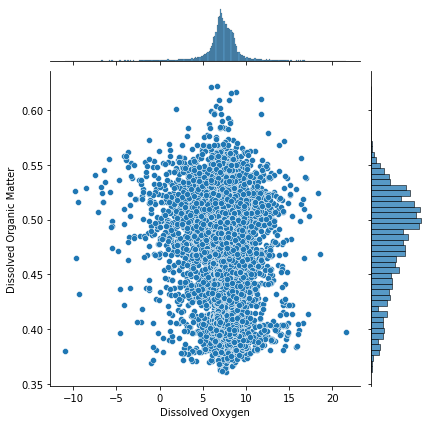

In [ ]:
import seaborn as sns
sns.jointplot(x='Dissolved Oxygen',y='Dissolved Organic Matter',data=df2)